## Import necessary library

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from transformers import BertModel
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm

os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', None)

If working on a local machine:

In [10]:
if os.path.exists('data/train/tokenized_train_data.pkl'):
    data = pd.read_pickle('data/train/tokenized_train_data.pkl')
else:
    print("File not found.")

If working in Google Colab:

In [2]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/'
data_path = os.path.join(base_path, 'NLP/data/train/tokenized_train_data.pkl')

if os.path.exists(data_path):
    data = pd.read_pickle(data_path)
else:
    print("File not found. Please ensure the file path is correct and run the previous cell to create the file.")

Mounted at /content/drive


## Initalize BERT Model

In [8]:
model_name = 'bert-base-uncased'
model = BertModel.from_pretrained(model_name)

## Train the model

In [4]:
# First, we need to drop any rows that failed to tokenize
data = data.dropna(subset=['tokenized'])
subset_train = data.iloc[:5000]

# Extract 'input_ids' and 'attention_mask' and create tensors
input_ids = torch.cat(subset_train['tokenized'].apply(lambda x: x['input_ids']).tolist())
attention_mask = torch.cat(subset_train['tokenized'].apply(lambda x: x['attention_mask']).tolist())
labels = torch.tensor(subset_train['hate'].values, dtype=torch.long)

## Check if CUDA is available, otherwise use CPU

In [5]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training")

Using cuda for training


## Create a DataLoader for the training and validation sets

In [6]:

# Assuming `input_ids`, `attention_mask`, and `labels` are your dataset's features
# and labels, respectively, and are all PyTorch tensors.
dataset = TensorDataset(input_ids, attention_mask, labels)

# Split the dataset into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

## Define the model and optimizer

In [7]:
# Define the number of epochs for training
num_epochs = 5

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)  # Move the model to the appropriate device (CPU or GPU)

# Prepare optimizer and schedule (linear warmup and decay)
optimizer = AdamW(model.parameters(), lr=2e-4)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training loop

In [ ]:
# Listen zur Speicherung der Verlustwerte
train_loss_values = []
val_loss_values = []
val_f1_scores = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_attention_mask, b_labels = batch

        optimizer.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        total_loss += loss.item()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)

    # Validation phase
    model.eval()
    total_val_loss = 0
    all_predictions = []
    all_true_labels = []
    for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}"):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_attention_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            batch_predictions = np.argmax(logits, axis=1).flatten()

            # Speichern der Vorhersagen und tatsächlichen Labels für später
            all_predictions.extend(batch_predictions)
            all_true_labels.extend(label_ids)

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_values.append(avg_val_loss)

    # F1-Score für das gesamte Validierungsset berechnen
    f1 = f1_score(all_true_labels, all_predictions, average='macro', zero_division=0)
    val_f1_scores.append(f1)

    print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}, Validation F1 Score: {f1:.4f}")

Training Epoch 1: 100%|██████████| 282/282 [02:06<00:00,  2.23it/s]
Validation Epoch 1: 100%|██████████| 32/32 [00:04<00:00,  7.00it/s]
Epoch 1 - Validation Loss: 0.3539, Validation F1 Score: 0.6908
Training Epoch 2: 100%|██████████| 282/282 [02:05<00:00,  2.25it/s]
Validation Epoch 2: 100%|██████████| 32/32 [00:04<00:00,  6.99it/s]
Epoch 2 - Validation Loss: 0.2279, Validation F1 Score: 0.8261
Training Epoch 3: 100%|██████████| 282/282 [02:05<00:00,  2.25it/s]
Validation Epoch 3: 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]
Epoch 3 - Validation Loss: 0.3583, Validation F1 Score: 0.7402
Training Epoch 4: 100%|██████████| 282/282 [02:05<00:00,  2.25it/s]
Validation Epoch 4: 100%|██████████| 32/32 [00:04<00:00,  6.99it/s]
Epoch 4 - Validation Loss: 0.1845, Validation F1 Score: 0.8731
Training Epoch 5: 100%|██████████| 282/282 [02:05<00:00,  2.25it/s]
Validation Epoch 5: 100%|██████████| 32/32 [00:04<00:00,  7.01it/s]
Epoch 5 - Validation Loss: 0.1942, Validation F1 Score: 0.8733

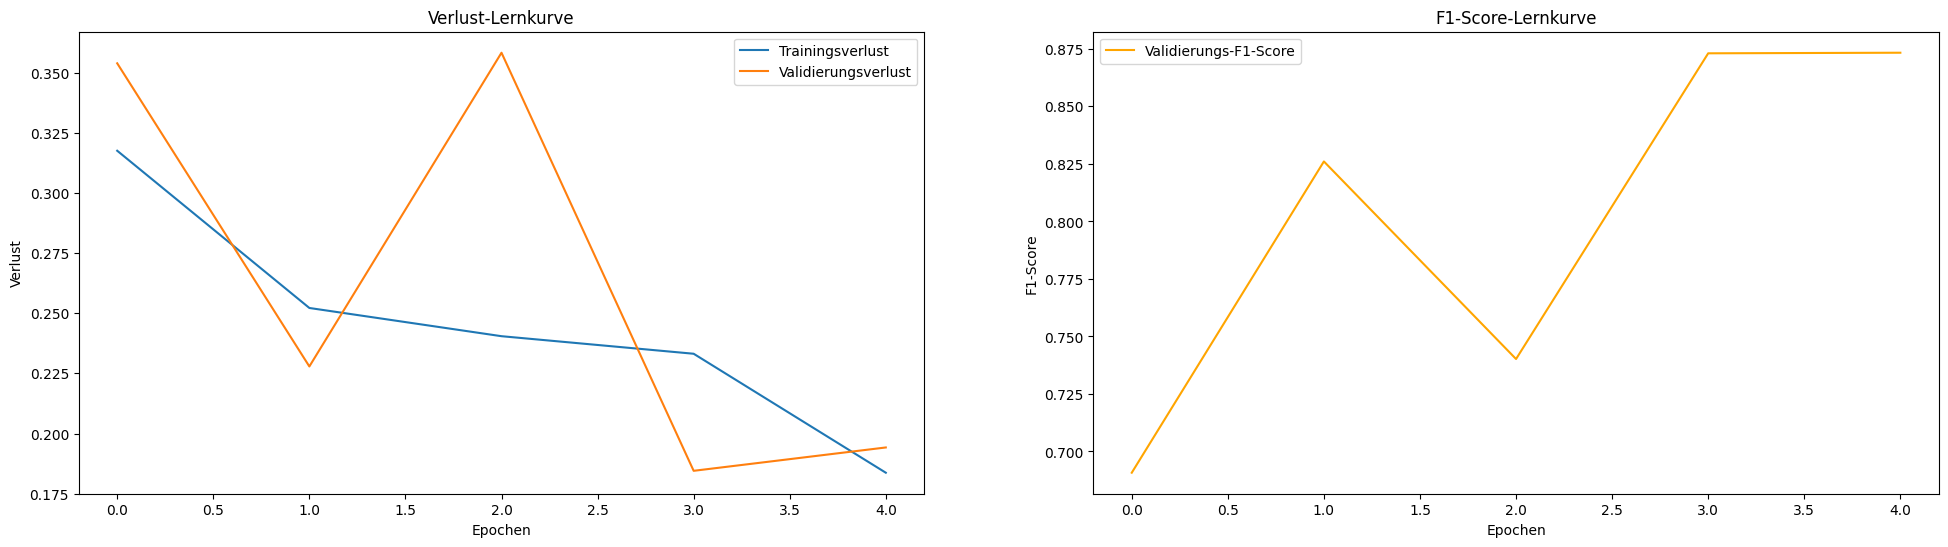

In [10]:
# Erstellen Sie eine Figur und ein Subplot-Grid von 1x2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

# Erster Plot: Verlust-Lernkurve
ax1.plot(train_loss_values, label='Trainingsverlust')
ax1.plot(val_loss_values, label='Validierungsverlust')
ax1.set_xlabel('Epochen')
ax1.set_ylabel('Verlust')
ax1.set_title('Verlust-Lernkurve')
ax1.legend()

# Zweiter Plot: F1-Score-Lernkurve
ax2.plot(val_f1_scores, label='Validierungs-F1-Score', color='orange')
ax2.set_xlabel('Epochen')
ax2.set_ylabel('F1-Score')
ax2.set_title('F1-Score-Lernkurve')
ax2.legend()

# Die Plots anzeigen
plt.show()


In [9]:
# base_path festlegen (bereits gegeben)
base_path = '/content/drive/My Drive/'

# data_path erstellen, falls er nicht existiert
data_path = os.path.join(base_path, 'NLP/classification_pipeline/model')
if not os.path.exists(data_path):
    os.makedirs(data_path)

# Dateiname für das gespeicherte Modell festlegen
model_file_path = os.path.join(data_path, 'model.pth')

# Modell speichern
torch.save(model.state_dict(), model_file_path)

print(f'Modell wurde erfolgreich unter {model_file_path} gespeichert.')

Modell wurde erfolgreich unter /content/drive/My Drive/NLP/classification_pipeline/model/model.pth gespeichert.
